In [1141]:
import os

os.environ["KERAS_BACKEND"] = "jax"
import keras
from keras import layers
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

In [1]:
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(["science", "notebook", "muted"])
plt.rcParams["text.usetex"] = False

In [4]:
import numpy as np

In [28]:
import sklearn
import sklearn.model_selection

In [648]:
import corner

In [770]:
import pandas as pd

In [254]:
X = np.load("X.npy")
coeffs = np.load("y.npy")
y = coeffs[:,0]

# just try non-spinning...
# mask_non_spinning = (np.abs(X[:,1]) < 1e-3) & (np.abs(X[:,2]) < 1e-3)

# X = X[mask_non_spinning, :2]
# y = y[mask_non_spinning]


In [255]:
X.shape

(312, 3)

In [256]:
y.shape

(312,)

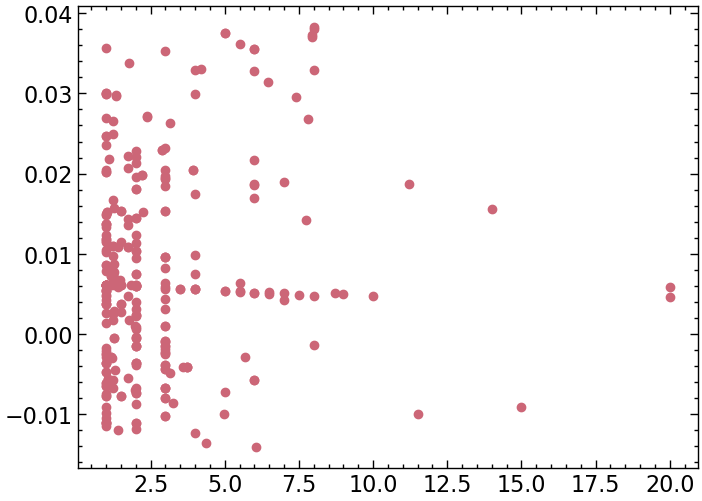

In [257]:
plt.scatter(X[:,0], y)

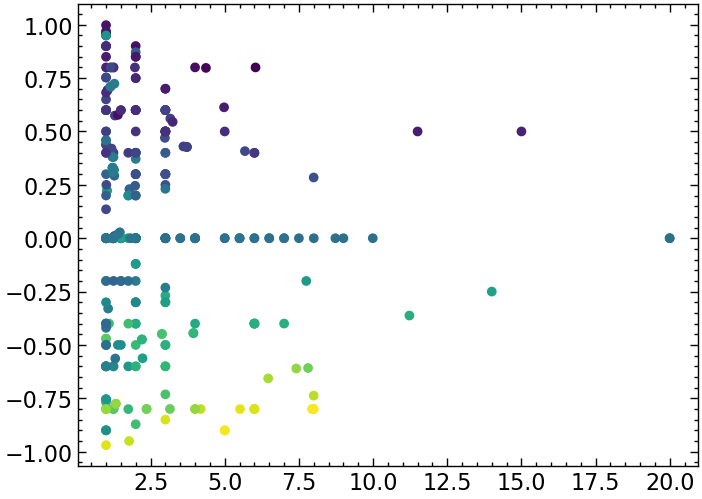

In [258]:
plt.scatter(X[:,0], X[:,1], c=y)

In [259]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((218, 3), (94, 3), (218,), (94,))

In [260]:
X_ss = sklearn.preprocessing.StandardScaler()
y_ss = sklearn.preprocessing.StandardScaler()

In [261]:
X_train_prime = X_ss.fit_transform(X_train)
X_test_prime = X_ss.transform(X_test)

In [262]:
y_train_prime = y_ss.fit_transform(y_train[:,np.newaxis])[:,0]
y_test_prime = y_ss.transform(y_test[:,np.newaxis])[:,0]

In [300]:
def tilted_loss(q, y, f):
    """
    Keras quantile loss from [here](https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb)
    and [here](https://github.com/cgarciae/quantile-regression)
    """
    e = y - f
    return jnp.mean(jnp.maximum(q * e, (q - 1) * e), axis=-1)

# def quantile_loss(q, y_true, y_pred):
#     e = y_true - y_pred
#     return jnp.maximum(q * e, (q - 1.0) * e)
#
def fit(X, y, alpha, epochs, batch_size, verbose, units, activations):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X.shape[1],)))
    for unit, act in zip(units, activations):
        model.add(layers.Dense(unit, activation=act))
    model.add(layers.Dense(1))

    model.compile(loss=lambda y, f: tilted_loss(alpha, y, f), optimizer="adam")
    # model.compile(loss='mse', optimizer="adam")

    callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience=100)
    # callback = keras.callbacks.EarlyStopping(monitor="loss", patience=100)

    history = model.fit(
        X,
        y,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        validation_split=0.2,
        callbacks=[callback],
    )
    return model, history


In [264]:
alpha = 0.5
units=[32,32,32]
model, history = fit(
    X_train_prime,
    y_train_prime,
    alpha,
    epochs=1000,
    batch_size=32,
    verbose=0,
    units=units,
    activations=['tanh']*len(units),
   )

In [265]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ls='--')

In [266]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], ls='--')
plt.yscale('log')

In [267]:
yhat_train_prime = model(X_train_prime)[:,0]
yhat_test_prime = model(X_test_prime)[:,0]

In [268]:
yhat_train = y_ss.inverse_transform(yhat_train_prime[:,np.newaxis])[:,0]
yhat_test = y_ss.inverse_transform(yhat_test_prime[:,np.newaxis])[:,0]

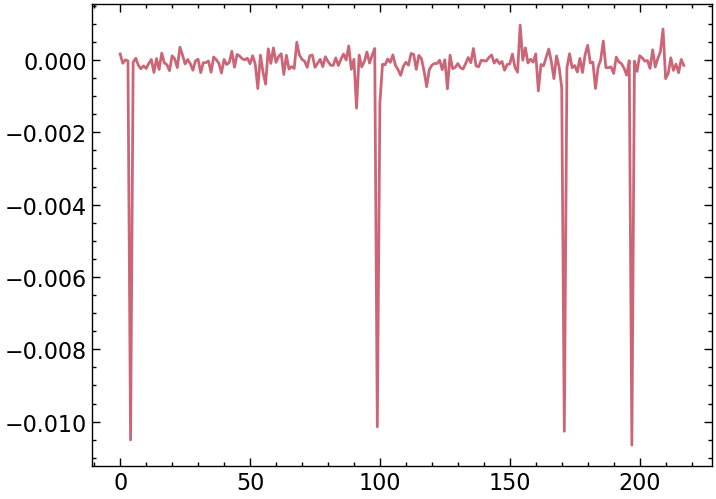

In [269]:
plt.figure()
plt.plot(y_train - yhat_train)

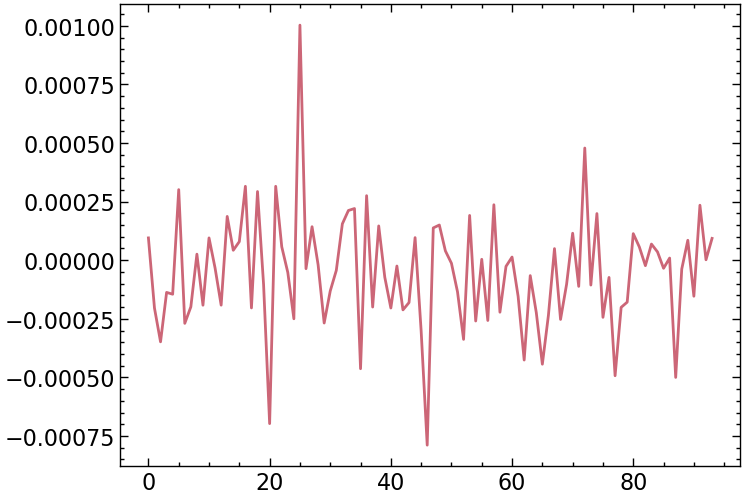

In [270]:
plt.figure()
plt.plot(y_test - yhat_test)

In [271]:
X_non_spinning = np.zeros(shape=(100, 3))
X_non_spinning_q = np.linspace(1, 20, 100)[:,np.newaxis]
X_non_spinning[:,0] = X_non_spinning_q[:,0]
X_non_spinning_prime = X_ss.transform(X_non_spinning)
yhat_ns_prime = model(X_non_spinning_prime)[:,0]
yhat_ns = y_ss.inverse_transform(yhat_ns_prime[:,np.newaxis])[:,0]

In [274]:
train_mask_non_spinning = (np.abs(X_train[:,1]) < 1e-3) & (np.abs(X_train[:,2]) < 1e-3)
test_mask_non_spinning = (np.abs(X_test[:,1]) < 1e-3) & (np.abs(X_test[:,2]) < 1e-3)

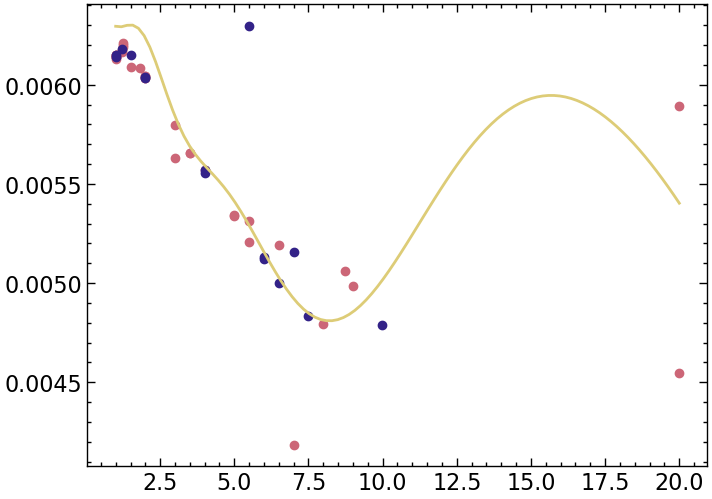

In [275]:
plt.plot(X_train[train_mask_non_spinning,0], y_train[train_mask_non_spinning], 'o', label='train')
plt.plot(X_test[test_mask_non_spinning,0], y_test[test_mask_non_spinning], 'o', label='test')
plt.plot(X_non_spinning[:,0], yhat_ns)

In [252]:
# # plot non-spinning
# X_non_spinning = np.zeros(shape=(100, 3))
# X_non_spinning[:,0] = np.linspace(1, 20, 100)
# X_non_spinning_prime = X_ss.transform(X_non_spinning)
# yhats_ns_prime = model(X_non_spinning_prime)[:,0]
# yhats_ns = y_ss.inverse_transform(yhats_ns_prime[:,np.newaxis])[:,0]

# train_mask_non_spinning = (np.abs(X_train[:,1]) < 1e-3) & (np.abs(X_train[:,2]) < 1e-3)
# test_mask_non_spinning = (np.abs(X_test[:,1]) < 1e-3) & (np.abs(X_test[:,2]) < 1e-3)

# plt.scatter(X_train[train_mask_non_spinning,0], y_train[train_mask_non_spinning], label='train', c='C1')
# plt.scatter(X_test[test_mask_non_spinning,0], y_test[test_mask_non_spinning], label='test', ec='C2', fc='none')
# plt.plot(X_non_spinning[:,0], yhats_ns)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# # plt.ylim(-0.1, 0.1)

In [304]:
alphas = [0.05, 0.5, 0.95]
units=[128]
activations=['selu']*len(units)
models = {}
historys = {}
for alpha in alphas:
    model, history = fit(
        X_train_prime,
        y_train_prime,
        alpha,
        epochs=1000,
        batch_size=32,
        verbose=0,
        units=units,
        activations=activations,
       )
    models[alpha] = model
    historys[alpha] = history

In [305]:
yhat_ns={}

X_non_spinning = np.zeros(shape=(100, 3))
X_non_spinning_q = np.linspace(1, 20, 100)[:,np.newaxis]
X_non_spinning[:,0] = X_non_spinning_q[:,0]
X_non_spinning_prime = X_ss.transform(X_non_spinning)

for alpha in alphas:
    yhat_ns_prime = models[alpha](X_non_spinning_prime)[:,0]
    yhat_ns[alpha] = y_ss.inverse_transform(yhat_ns_prime[:,np.newaxis])[:,0]

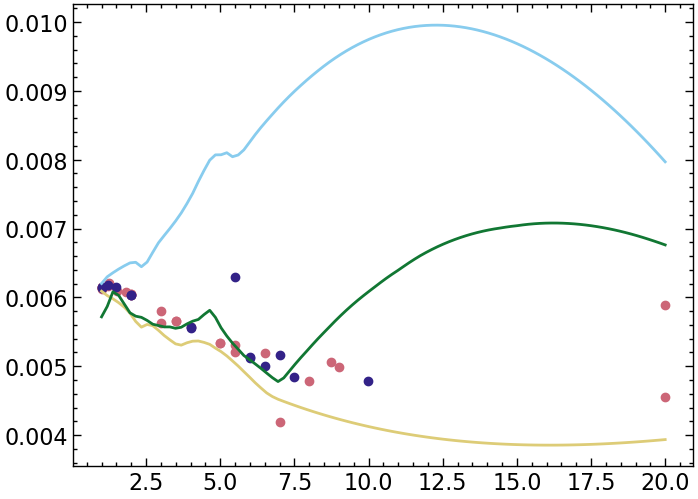

In [306]:
plt.plot(X_train[train_mask_non_spinning,0], y_train[train_mask_non_spinning], 'o', label='train')
plt.plot(X_test[test_mask_non_spinning,0], y_test[test_mask_non_spinning], 'o', label='test')
plt.plot(X_non_spinning[:,0], yhat_ns[0.05])
plt.plot(X_non_spinning[:,0], yhat_ns[0.5])
plt.plot(X_non_spinning[:,0], yhat_ns[0.95])

In [333]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import QuantileRegressor

def fit_qr(X, y, deg):
    
    # Create polynomial features
    poly = PolynomialFeatures(degree=deg)
    X_poly = poly.fit_transform(X)
    
    
    # Fit a quantile regression model
    def fit_quantile(x, y, quantile):
        model = QuantileRegressor(quantile=alpha)
        model.fit(x, y)
        return model

    alphas=[0.05, 0.5, 0.95]
    models = {}
    for alpha in alphas:
        models[alpha] = fit_quantile(X_poly, y, alpha)
        
    # # Make predictions
    # X_new = np.linspace(0, 10, 100)[:,np.newaxis]
    # # X_new = np.array([[6], [7]])

    # y_preds = {}
    # for alpha in alphas:
    #     y_preds[alpha] = models[alpha].predict(poly.transform(X_new))
    
    # # print(y_pred)

    # plt.plot(X_train, y_train, 'o')
    # for alpha in alphas:
    #     plt.plot(X_new, y_preds[alpha])
    return models, poly

In [345]:
models, poly = fit_qr(X[mask_non_spinning, 0][:,np.newaxis], y[mask_non_spinning], 4)
yhat_qr={}
for alpha in alphas:
    yhat_qr[alpha] = models[alpha].predict(poly.transform(X_non_spinning[:,:1]))
plt.plot(X[mask_non_spinning, 0][:,np.newaxis], y[mask_non_spinning], 'o')
plt.plot(X_non_spinning[:,0], yhat_qr[0.05])
plt.plot(X_non_spinning[:,0], yhat_qr[0.5])
plt.plot(X_non_spinning[:,0], yhat_qr[0.95])

# non-spinning eqr

In [350]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor

In [947]:
X = np.load("X.npy")
coeffs = np.load("y.npy")
y = coeffs[:,0]

# just try non-spinning...
# mask_non_spinning = (np.abs(X[:,1]) < 1e-3) & (np.abs(X[:,2]) < 1e-3)

X = X[mask_non_spinning, 0]
y = y[mask_non_spinning]

X = X[:,np.newaxis]

In [948]:
X.shape

(50, 1)

In [949]:
y.shape

(50,)

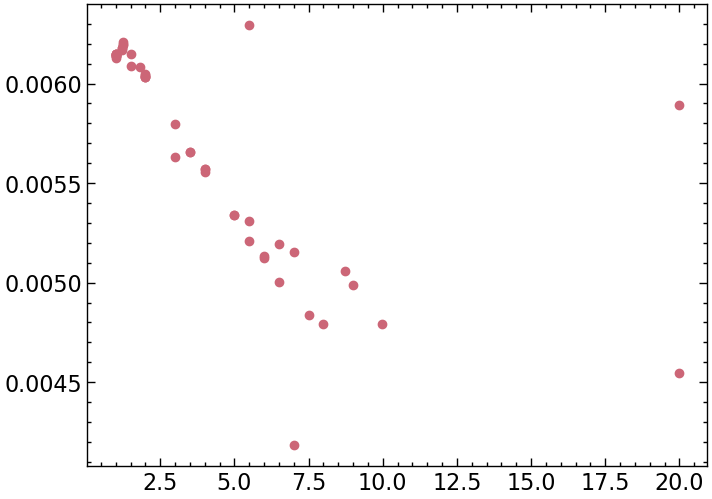

In [950]:
plt.scatter(X, y)

In [951]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

In [402]:
# method = "gbr"
# method = "ann"
method = "lgb"
eqr_model = EpistemicQuantileRegressor([(1, 30)], 1000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=0.0001,
    gm_kwargs={"n_components": 3},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(35, 1) (15, 1) (718, 1) (753, 1)


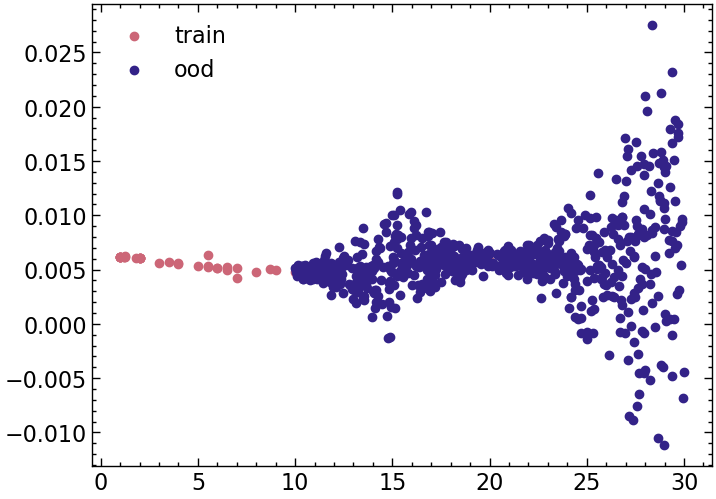

In [403]:
plt.figure()
plt.scatter(X_train, y_train, label="train")
plt.scatter(X_ood, y_ood, label="ood")
plt.legend()
# plt.xlim(0, 10)
# plt.ylim(-20, 20)
plt.show()

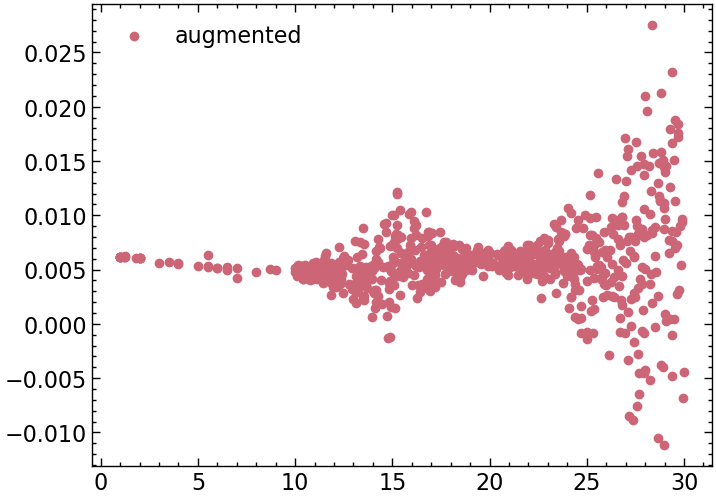

In [404]:

plt.figure()
plt.scatter(X_aug, y_aug, label="augmented")
plt.legend()
plt.show()


In [419]:
xx = np.linspace(1, 30, 100)[:,np.newaxis]
models, poly = fit_qr(X_aug, y_aug, 10)
yhat_qr={}
for alpha in alphas:
    yhat_qr[alpha] = models[alpha].predict(poly.transform(xx))
plt.plot(X_aug, y_aug, 'o')
plt.plot(xx, yhat_qr[0.05])
plt.plot(xx, yhat_qr[0.5])
plt.plot(xx, yhat_qr[0.95])
plt.ylim(-0.005,0.01)

(-0.005, 0.01)

In [438]:
%%time
if method == "ann":
    params = dict(epochs=1000, batch_size=32, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=30,
        # fixed_params={"num_leaves": 31},
        fixed_params={"num_iterations": 100},
        # fixed_params=None,
        search_params=[["num_leaves", "int", 31, 3100]],
        cv_params={"nfold": 2},
    )
else:
    raise ValueError(f"unknown {method = }")

eqr_model.fit(X_aug, y_aug, **params)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

CPU times: user 42.2 s, sys: 6.4 s, total: 48.6 s
Wall time: 48.8 s


In [439]:
for k in eqr_model.study.keys():
    print(k, eqr_model.study[k].best_params)

0.05 {'num_leaves': 36}
0.5 {'num_leaves': 32}
0.95 {'num_leaves': 36}


In [440]:
for k in eqr_model.params.keys():
    print(k, eqr_model.params[k])

0.05 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.05, 'num_leaves': 36}
0.5 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.5, 'num_leaves': 32}
0.95 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.95, 'num_leaves': 36}


In [441]:
yhats = eqr_model.predict(xx)

In [442]:
plt.plot(X_aug, y_aug, 'o')
plt.plot(X_test, y_test, 'o')
plt.plot(xx, yhats[0])
plt.plot(xx, yhats[1])
plt.plot(xx, yhats[2])
plt.ylim(0,0.015)

(0.0, 0.015)

# spinning eqr

In [1000]:
from eqr.epistemic_quantile_regressor import EpistemicQuantileRegressor

In [1001]:
X = np.load("X.npy")
coeffs = np.load("y.npy")
y = coeffs[:,0]

In [1002]:
X.shape

(312, 3)

In [1003]:
y.shape

(312,)

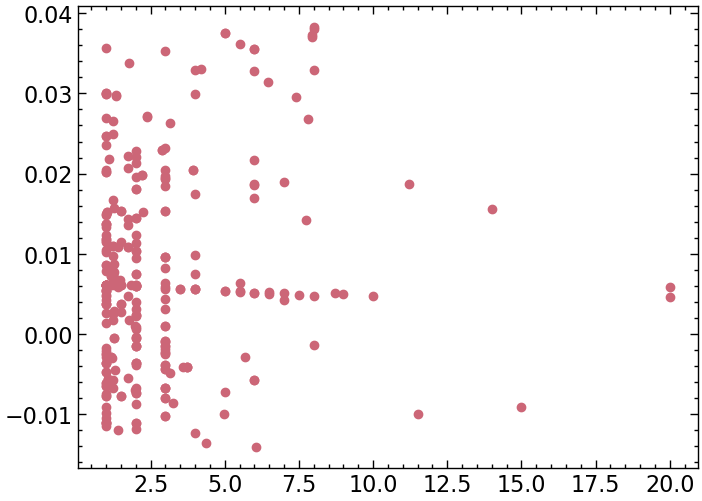

In [1004]:
plt.scatter(X[:,0], y)

In [1005]:
# X_ss = sklearn.preprocessing.StandardScaler()
y_ss = sklearn.preprocessing.StandardScaler()

# X = X_ss.fit_transform(X)
y = y_ss.fit_transform(y[:,np.newaxis])[:,0]

In [1006]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

In [1007]:
# method = "gbr"
# method = "ann"
method = "lgb"
eqr_model = EpistemicQuantileRegressor([(1, 30),(-1, 1), (-1, 1)], 1000, method=method)
# eqr_model = EpistemicQuantileRegressor([(-0.7, 8),(-2, 2), (-2, 2)], 1000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=0.1,
    gm_kwargs={"n_components": 10},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(218, 3) (94, 3) (850, 3) (1068, 3)


In [1008]:
y_train.std()

1.0369522323411071

In [1009]:
plt.figure()
plt.scatter(X_train[:,0], y_train, label="train")
plt.scatter(X_test[:,0], y_test, label="test")
plt.scatter(X_ood[:,0], y_ood, label="ood")
plt.legend()
# plt.xlim(0, 10)
# plt.ylim(-20, 20)
plt.show()

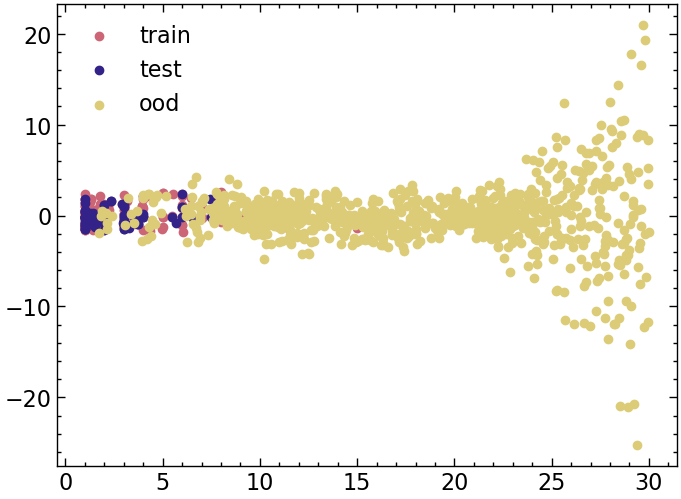

In [1010]:
plt.figure()
plt.scatter(X_train[:,0], y_train, label="train")
plt.scatter(X_test[:,0], y_test, label="test")
plt.scatter(X_ood[:,0], y_ood, label="ood")
plt.legend()
# plt.xlim(0, 10)
# plt.ylim(-20, 20)
plt.show()

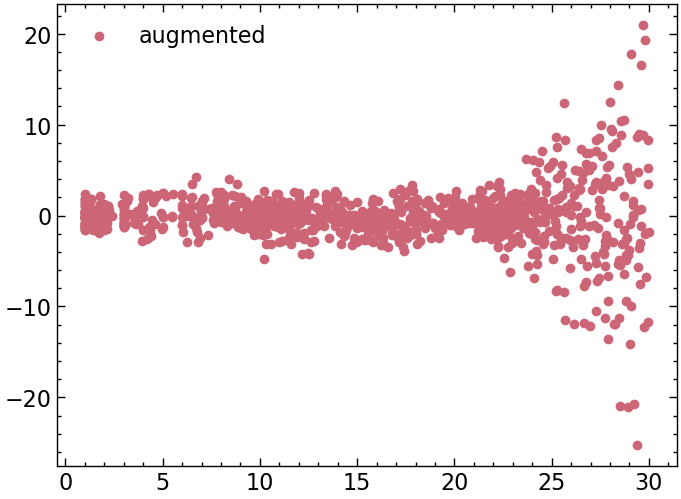

In [1011]:

plt.figure()
plt.scatter(X_aug[:,0], y_aug, label="augmented")
plt.legend()
plt.show()


In [1012]:
fig = corner.corner(
    X_train, plot_datapoints=True, plot_contours=False, plot_density=False, color='C0', hist_kwargs={'density':True},  data_kwargs={"ms": 10, 'color':"C0", 'alpha':1}, labels=['q', r'$\chi_1$', r'$\chi_2$']
);

fig = corner.corner(
    X_test, plot_datapoints=True, plot_contours=False, plot_density=False, color='C1', hist_kwargs={'density':True}, data_kwargs={"ms": 10, 'color':'C1', 'alpha':1}, fig=fig
);
fig = corner.corner(
    X_ood, plot_datapoints=True, plot_contours=False, plot_density=False, color='C2', hist_kwargs={'density':True}, data_kwargs={"ms": 10, 'color':'none', 'alpha':0.5, 'mec':'C2'}, fig=fig
);

In [1013]:
%%time
if method == "ann":
    params = dict(epochs=1000, batch_size=32, verbose=0)
elif method == "gbr":
    params = dict(n_trials=100)
elif method == "lgb":
    params = dict(
        n_trials=100,
        # fixed_params={"num_leaves": 31},
        fixed_params={"num_iterations": 100},
        # fixed_params=None,
        search_params=[["num_leaves", "int", 31, 3100]],
        cv_params={"nfold": 2},
    )
else:
    raise ValueError(f"unknown {method = }")

eqr_model.fit(X_aug, y_aug, **params)

  0%|          | 0/100 [00:00<?, ?it/s]

/home/sebastian.khan/.conda/envs/ppmhm/lib/python3.10/site-packages/lightgbm/engine.py:738: UserWarning: Found 'num_iterations' in params. Will use it instead of 'num_boost_round' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'num_boost_round' argument")
/home/sebastian.khan/.conda/envs/ppmhm/lib/python3.10/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: user 3min 2s, sys: 20 s, total: 3min 22s
Wall time: 3min 23s


In [1014]:
for k in eqr_model.study.keys():
    print(k, eqr_model.study[k].best_params)

0.05 {'num_leaves': 33}
0.5 {'num_leaves': 35}
0.95 {'num_leaves': 31}


In [1015]:
for k in eqr_model.params.keys():
    print(k, eqr_model.params[k])

0.05 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.05, 'num_leaves': 33}
0.5 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.5, 'num_leaves': 35}
0.95 {'objective': 'quantile', 'metric': 'quantile', 'num_iterations': 100, 'max_depth': -1, 'learning_rate': 0.1, 'verbose': -1, 'min_data_in_leaf': 1, 'seed': 5093840343, 'num_threads': 0, 'alpha': 0.95, 'num_leaves': 31}


In [1016]:
yhats_train = eqr_model.predict(X_train)
yhats_test = eqr_model.predict(X_test)

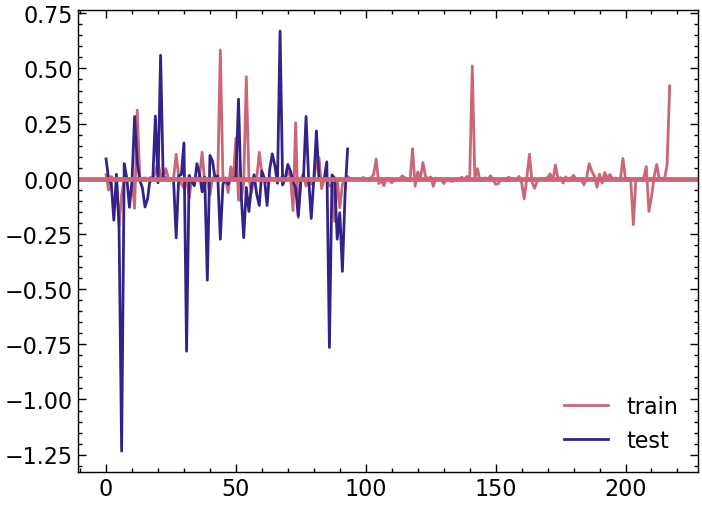

In [1017]:
plt.plot(yhats_train[1][:,0] - y_train, label='train')
plt.plot(yhats_test[1][:,0] - y_test, label='test')
plt.axhline(0.005)
plt.axhline(-0.005)
plt.legend()

In [1018]:
# generate some test data over the grid but remember to scale the X data if needed

D = len(eqr_model.synthetic_data_domain)
min_values = [v[0] for v in eqr_model.synthetic_data_domain]
max_values = [v[1] for v in eqr_model.synthetic_data_domain]

# min_values[2]=0
# max_values[2]=0

xx = np.random.uniform(
    low=min_values, high=max_values, size=(10000, D)
)


# xx = X_ss.transform(xx)

In [1019]:
yhats = eqr_model.predict(xx)

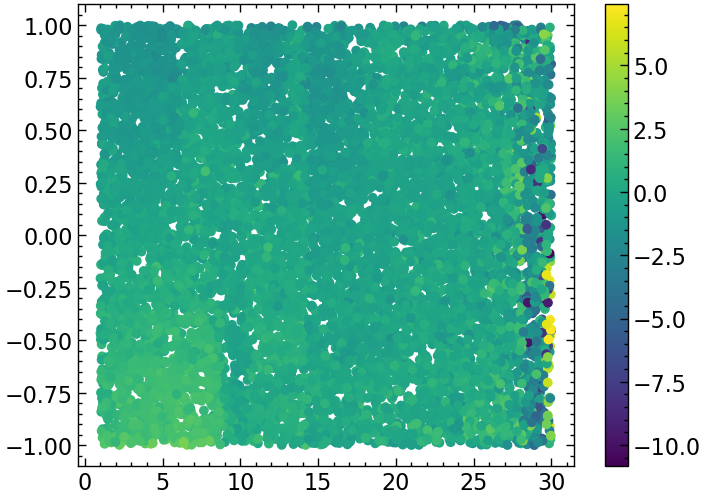

In [1020]:
plt.figure()
# plt.scatter(X[:,0], X[:,1], label='train')
# plt.scatter(X_ood[:,0], X_ood[:,1], label='ood')
plt.scatter(xx[:,0], xx[:,1], c=yhats[1][:,0])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.colorbar()

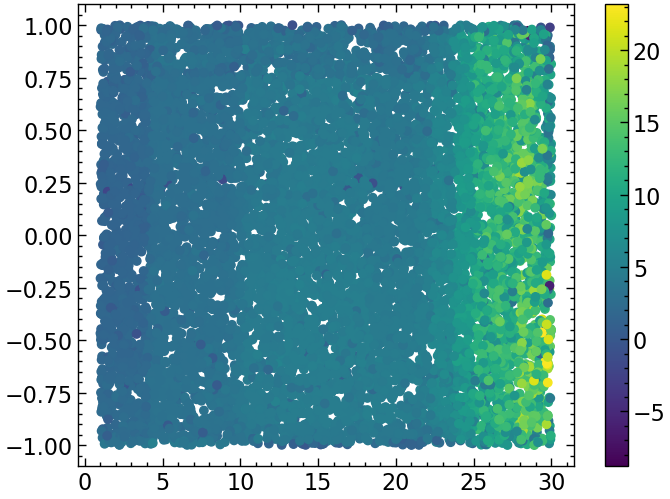

In [1021]:
plt.figure()
# plt.scatter(X[:,0], X[:,1], label='train')
# plt.scatter(X_ood[:,0], X_ood[:,1], label='ood')
plt.scatter(xx[:,0], xx[:,1], c=yhats[2][:,0]-yhats[0][:,0])
# plt.scatter(xx[:,0], xx[:,1], c=np.log10(np.abs(yhats[2][:,0]-yhats[0][:,0])))
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.colorbar()

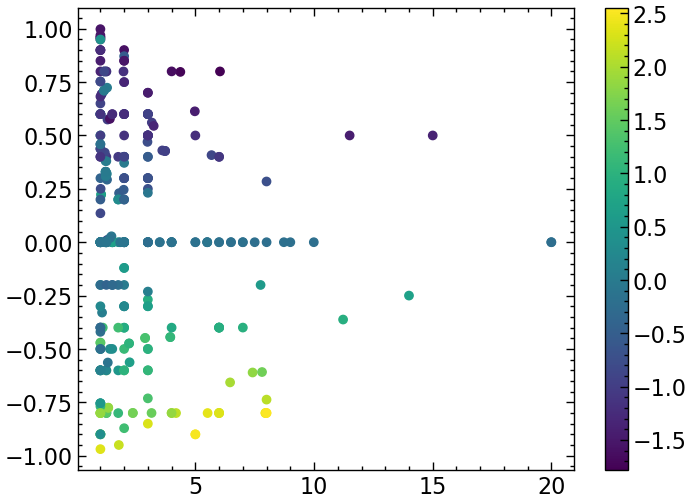

In [1022]:
plt.figure()
plt.scatter(X[:,0], X[:,1], c=y)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.colorbar()

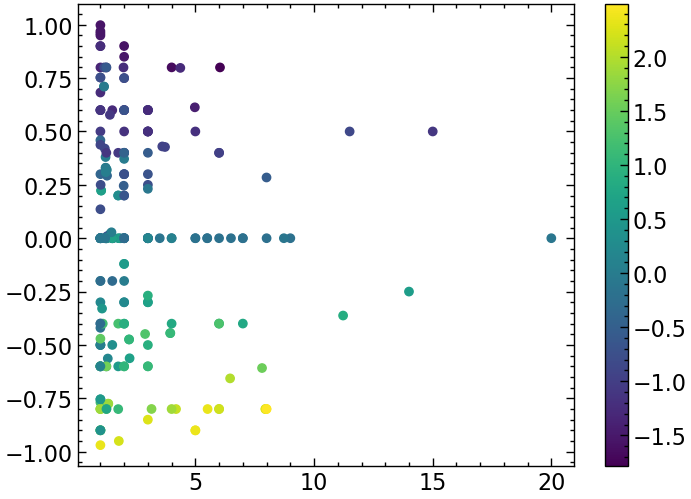

In [1036]:
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=yhats_train[1][:,0])
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.colorbar()

In [1023]:
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=y_train - yhats_train[1][:,0])
plt.colorbar()

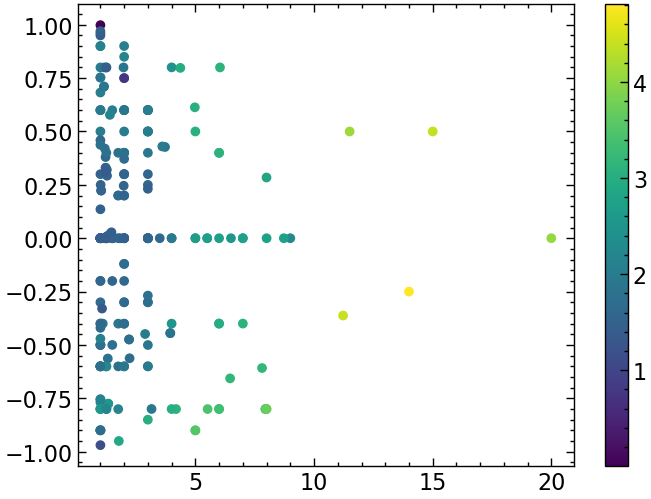

In [1024]:
plt.figure()
plt.scatter(X_train[:,0], X_train[:,1], c=yhats_train[2][:,0]-yhats_train[0][:,0])
plt.colorbar()

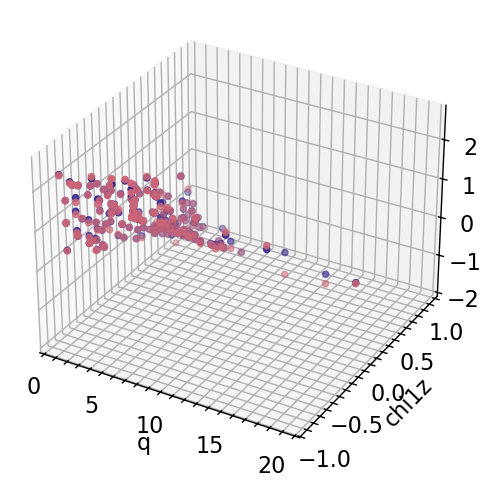

In [1025]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_train[:,0], X_train[:,1], y_train)
ax.scatter(X_train[:,0], X_train[:,1], yhats_train[1][:,0])
ax.set_xlabel("q")
ax.set_ylabel("chi1z")
plt.show()
plt.close()

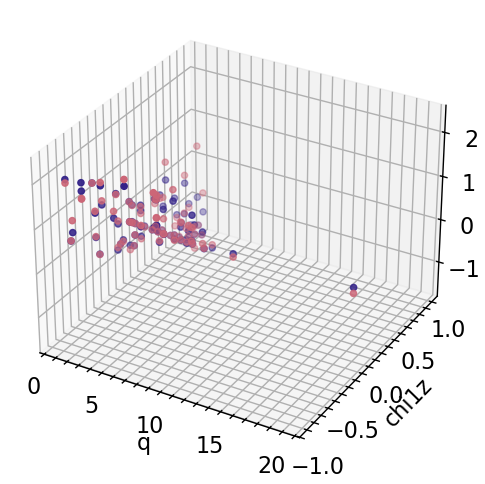

In [1026]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], y_test)
ax.scatter(X_test[:,0], X_test[:,1], yhats_test[1][:,0])
ax.set_xlabel("q")
ax.set_ylabel("chi1z")
plt.show()
plt.close()

In [1027]:
plt.figure(figsize=(14, 4))
x_ = np.arange(len(y_train))

y0=yhats_train[0][:,0]
y1=yhats_train[1][:,0]
y2=yhats_train[2][:,0]


ylow = np.abs(y1-y0)
yhigh = np.abs(y2-y1)

plt.errorbar(x_, y1, yerr=[ylow, yhigh], fmt='x', capsize=3, elinewidth=1, markeredgewidth=1)

# plt.plot(x_, y0, '+', ms=20)
# plt.plot(x_, y1, '+', ms=20)
# plt.plot(x_, y2, '+', ms=20)

plt.plot(x_, y_train, 'o')


# plt.xlim(-1, 10)

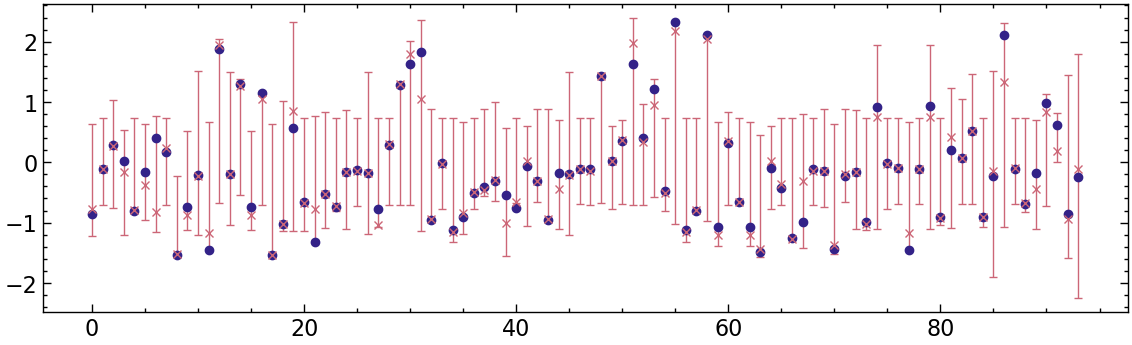

In [1028]:
plt.figure(figsize=(14, 4))
x_ = np.arange(len(y_test))

y0=yhats_test[0][:,0]
y1=yhats_test[1][:,0]
y2=yhats_test[2][:,0]


ylow = np.abs(y1-y0)
yhigh = np.abs(y2-y1)

plt.errorbar(x_, y1, yerr=[ylow, yhigh], fmt='x', capsize=3, elinewidth=1, markeredgewidth=1)

# plt.plot(x_, y0, '+', ms=20)
# plt.plot(x_, y1, '+', ms=20)
# plt.plot(x_, y2, '+', ms=20)

plt.plot(x_, y_test, 'o')


# plt.xlim(-1, 10)

In [1029]:
# generate non-spinning line
# generate some test data over the grid but remember to scale the X data if needed

D = len(eqr_model.synthetic_data_domain)
min_values = [v[0] for v in eqr_model.synthetic_data_domain]
max_values = [v[1] for v in eqr_model.synthetic_data_domain]

min_values[1]=0
max_values[1]=0


min_values[2]=0
max_values[2]=0

xx = np.random.uniform(
    low=min_values, high=max_values, size=(1000, D)
)



# xx = X_ss.transform(xx)

In [1030]:
xx = pd.DataFrame(xx).sort_values(by=0, ascending=True).reset_index(drop=True).values

In [1031]:
yhats = eqr_model.predict(xx)

In [1032]:
xx

array([[ 1.05705537,  0.        ,  0.        ],
       [ 1.06516927,  0.        ,  0.        ],
       [ 1.12459955,  0.        ,  0.        ],
       ...,
       [29.92671863,  0.        ,  0.        ],
       [29.93000082,  0.        ,  0.        ],
       [29.98068164,  0.        ,  0.        ]])

In [1039]:
plt.plot(xx[:,0],yhats[1][:,0], c='C3')
plt.fill_between(xx[:,0],yhats[0][:,0], yhats[2][:,0], color='C3', alpha=0.5)
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_test[:,0], y_test)

# plt.scatter(X_ood[:,0], y_ood)
# plt.ylim(-2, 2)

In [1033]:
plt.plot(xx[:,0],yhats[1][:,0], c='C3')
plt.fill_between(xx[:,0],yhats[0][:,0], yhats[2][:,0], color='C3', alpha=0.5)
plt.scatter(X_train[:,0], y_train)
plt.scatter(X_test[:,0], y_test)

plt.scatter(X_ood[:,0], y_ood)


# rff learn quantile regression

In [1274]:

# Import 3rd-party packages.
import sklearn.linear_model

# Import custom modules.
from rfflearn.cpu.rfflearn_cpu_common import Base
# from .rfflearn_cpu_common import Base


class Regressor(Base):
    """
    Regression with random matrix (RFF/ORF).
    """
    def __init__(self, rand_type, quantile, alpha, dim_kernel=16, std_kernel=0.1, W=None, b=None, **args):
        """
        Constractor. Save hyper parameters as member variables and create LinearRegression instance.

        Args:
            rand_type  (str)       : Type of random matrix ("rff", "orf", "qrf", etc).
            dim_kernel (int)       : Dimension of the random matrix.
            std_kernel (float)     : Standard deviation of the random matrix.
            W          (np.ndarray): Random matrix for input `X` (generated automatically if None).
            b          (np.ndarray): Random bias for input `X` (generated automatically if None).
            args       (dict)      : Extra arguments. This arguments will be passed to
                                     the constructor of sklearn's LinearRegression model.
        """
        super().__init__(rand_type, dim_kernel, std_kernel, W, b)
        self.quantile = quantile
        self.alpha=alpha
        # self.reg = sklearn.linear_model.LinearRegression(**args)
        self.reg = sklearn.linear_model.QuantileRegressor(quantile=self.quantile, alpha=self.alpha)

    def fit(self, X, y, **args):
        """
        Trains the RFF regression model according to the given data.

        Args:
            X    (np.ndarray): Input matrix with shape (n_samples, n_features_input).
            y    (np.ndarray): Output vector with shape (n_samples,).
            args (dict)      : Extra arguments. This arguments will be passed to the sklearn's
                               `fit` function.

        Returns:
            (rfflearn.cpu.Regression): Fitted estimator.
        """
        self.set_weight(X.shape[1])
        self.reg.fit(self.conv(X), y, **args)
        return self

    def predict(self, X, **args):
        """
        Performs prediction on the given data.

        Args:
            X    (np.ndarray): Input matrix with shape (n_samples, n_features_input).
            args (dict)      : Extra arguments. This arguments will be passed to the sklearn's
                               `predict` function.

        Returns:
            (np.ndarray): Predicted vector.
        """
        self.set_weight(X.shape[1])
        return self.reg.predict(self.conv(X), **args)

    def score(self, X, y, **args):
        """
        Returns the R2 score (coefficient of determination) of the prediction.

        Args:
            X    (np.ndarray): Input matrix with shape (n_samples, n_features_input).
            y    (np.ndarray): Output vector with shape (n_samples,).
            args (dict)      : Extra arguments. This arguments will be passed to sklearn's
                               `score` function.

        Returns:
            (float): R2 score of the prediction.
        """
        self.set_weight(X.shape[1])
        return self.reg.score(self.conv(X), y, **args)


In [1292]:
X = np.load("X.npy")
coeffs = np.load("y.npy")
y = coeffs[:,0]

# just try non-spinning...
mask_non_spinning = (np.abs(X[:,1]) < 1e-3) & (np.abs(X[:,2]) < 1e-3)

X = X[mask_non_spinning, :1]
y = y[mask_non_spinning]

y_ss = sklearn.preprocessing.StandardScaler()
y = y_ss.fit_transform(y.reshape(-1, 1))[:,0]

In [1293]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

In [1277]:
# method = "gbr"
# method = "ann"
method = "lgb"
eqr_model = EpistemicQuantileRegressor([(1, 30)], 1000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=0.1,
    gm_kwargs={"n_components": 3},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(35, 1) (15, 1) (725, 1) (760, 1)


In [1278]:
plt.plot(X, y, 'o')
plt.plot(X_aug, y_aug, 'o')

In [1282]:
alphas = [0.05, 0.5, 0.95]
reg={}
yhat = {}
xx = np.linspace(1,30, 100)[:,np.newaxis]
a = {0.05:1e-3, 0.5:1e-3, 0.95:1e-3}
# rff
# orf
# qrf

for alpha in alphas:
    reg[alpha] = Regressor('rff', alpha, a[alpha], 512, 0.5)
    reg[alpha].fit(X_aug, y_aug)
    yhat[alpha] = reg[alpha].predict(xx)

In [1283]:
plt.plot(X, y, 'o')
# plt.plot(X_aug, y_aug, 'o')
for alpha in alphas:
    plt.plot(xx, yhat[alpha], '-')

## Augmented data and GPR?


In [1135]:
import sklearn.gaussian_process
def fit_coeffs_sklearn(X, y):
    # std_error = y_train.std()
    # kfn = sklearn.gaussian_process.kernels.RBF(1.0 / std_kernel)
    # kfn = sklearn.gaussian_process.kernels.RBF()
    # kfn = sklearn.gaussian_process.kernels.RationalQuadratic()
    # kfn = sklearn.gaussian_process.kernels.ExpSineSquared()
    kfn = sklearn.gaussian_process.kernels.Matern() + sklearn.gaussian_process.kernels.WhiteKernel()
    gpr = sklearn.gaussian_process.GaussianProcessRegressor(kernel=kfn, normalize_y=True)
    gpr.fit(X, y)
    return gpr

In [1136]:
gpr = fit_coeffs_sklearn(X_aug, y_aug)

In [1137]:
gpr.kernel_

Matern(length_scale=52.1, nu=1.5) + WhiteKernel(noise_level=0.99)

In [1138]:
yhat_gpr, yhat_gpr_std = gpr.predict(xx, return_std=True)

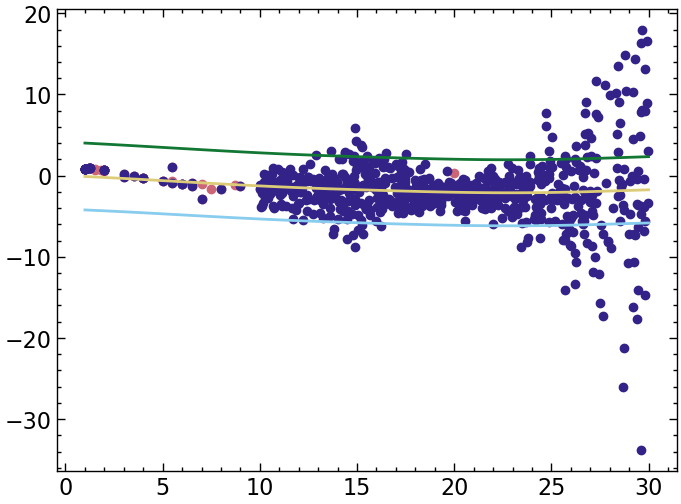

In [1139]:
plt.plot(X, y, 'o')
plt.plot(X_aug, y_aug, 'o')
plt.plot(xx, yhat_gpr)
plt.plot(xx, yhat_gpr+yhat_gpr_std)
plt.plot(xx, yhat_gpr-yhat_gpr_std)

## try tinygp and this [paper](https://www.researchgate.net/publication/281347768_Sensor_Calibration_and_Hysteresis_Compensation_With_Heteroscedastic_Gaussian_Processes#fullTextFileContent)

In [ ]:
# https://tinygp.readthedocs.io/en/stable/tutorials/intro.html
# https://tinygp.readthedocs.io/en/stable/tutorials/modeling.html

In [1304]:
import tinygp

from tinygp import GaussianProcess

from tinygp import kernels

import flax.linen as nn


import flax.linen as nn
from flax.linen.initializers import zeros

import optax




In [1305]:


class GPModule(nn.Module):
    @nn.compact
    def __call__(self, x, yerr, y, t):
        mean = self.param("mean", zeros, ())
        log_jitter = self.param("log_jitter", zeros, ())

        log_sigma1 = self.param("log_sigma1", zeros, ())
        log_rho1 = self.param("log_rho1", zeros, ())
        log_tau = self.param("log_tau", zeros, ())
        kernel1 = (
            jnp.exp(2 * log_sigma1)
            * kernels.ExpSquared(jnp.exp(log_tau))
            * kernels.Cosine(jnp.exp(log_rho1))
            # * kernels.RationalQuadratic(jnp.exp(log_rho1))
        )

        log_sigma2 = self.param("log_sigma2", zeros, ())
        log_rho2 = self.param("log_rho2", zeros, ())
        # kernel2 = jnp.exp(2 * log_sigma2) * kernels.Matern52(jnp.exp(log_rho2))
        kernel2 = jnp.exp(2 * log_sigma2) * kernels.RationalQuadratic(scale=jnp.exp(log_rho2), alpha=jnp.exp(log_tau))

        # kernel = kernel1 + kernel2
        kernel = kernel2
        # gp = GaussianProcess(kernel, x, diag=yerr**2 + jnp.exp(log_jitter), mean=mean)
        gp = GaussianProcess(kernel, x, diag=jnp.exp(log_jitter), mean=mean)

        log_prob, gp_cond = gp.condition(y, t)
        return -log_prob, gp_cond.loc, gp_cond.variance


def loss(params):
    return model.apply(params, t, yerr, y, true_t)[0]

In [1306]:
t = X_train
# t = X_aug
yerr = y_train.std()
y = y_train
# y = y_aug
true_t = xx

model = GPModule()

params = model.init(jax.random.PRNGKey(0), t, yerr, y, true_t)
tx = optax.sgd(learning_rate=3e-3)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss))

losses = []
for i in range(5001):
    loss_val, grads = loss_grad_fn(params)
    losses.append(loss_val)
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)

plt.plot(losses)
plt.ylabel("negative log likelihood")
_ = plt.xlabel("step number")

In [1307]:
mu = model.apply(params, t, yerr, y, true_t)[1]

In [1308]:
var = model.apply(params, t, yerr, y, true_t)[2]

In [1309]:
params

{'params': {'log_jitter': Array(-1.84306248, dtype=float64),
  'log_rho1': Array(0., dtype=float64),
  'log_rho2': Array(0.36643928, dtype=float64),
  'log_sigma1': Array(0., dtype=float64),
  'log_sigma2': Array(-0.1039743, dtype=float64),
  'log_tau': Array(0.33637992, dtype=float64),
  'mean': Array(-0.28477496, dtype=float64)}}

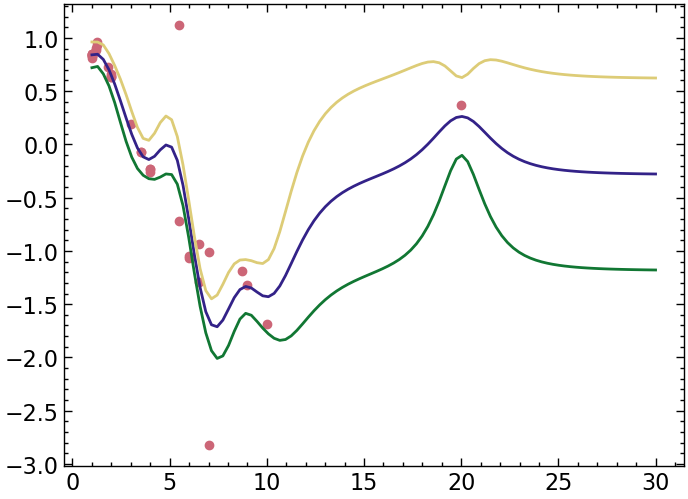

In [1310]:
plt.plot(t, y, 'o')
plt.plot(true_t, mu)
plt.plot(true_t, mu+np.sqrt(var))
plt.plot(true_t, mu-np.sqrt(var))

# RFF GPR

In [1311]:
import rfflearn.tuner

In [1312]:
# Import rfflearn.
import rfflearn.cpu

In [1546]:
X = np.load("X.npy")
coeffs = np.load("y.npy")
# y = coeffs[:,0]
y = coeffs[:,1]

# just try non-spinning...
mask_non_spinning = (np.abs(X[:,1]) < 1e-3) & (np.abs(X[:,2]) < 1e-3)

X = X[mask_non_spinning, :1]
y = y[mask_non_spinning]

y_ss = sklearn.preprocessing.StandardScaler()
y = y_ss.fit_transform(y.reshape(-1, 1))[:,0]

In [1547]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.3)

In [1548]:
# method = "gbr"
# method = "ann"
method = "lgb"
eqr_model = EpistemicQuantileRegressor([(1, 30)], 1000, method=method)

X_ood, y_ood = eqr_model.generate_synthetic_ood_data(
    X_train,
    y_train,
    scaling_factor=0.1,
    gm_kwargs={"n_components": 3},
)

X_aug, y_aug = eqr_model.augment_training_data(X_train, y_train, X_ood, y_ood)


print(X_train.shape, X_test.shape, X_ood.shape, X_aug.shape)


(35, 1) (15, 1) (678, 1) (713, 1)


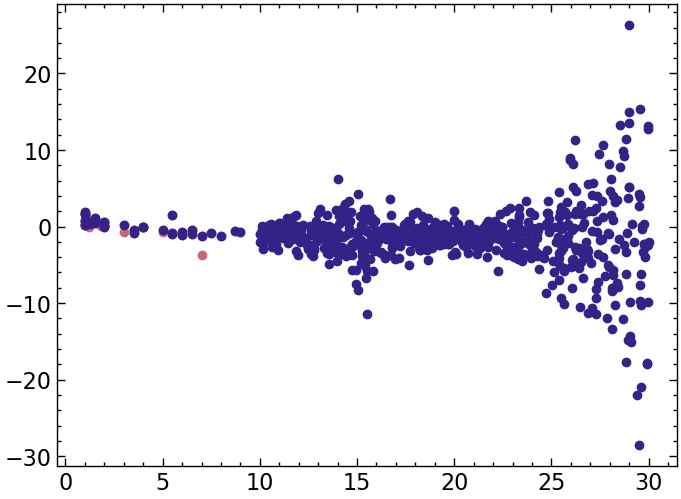

In [1549]:
plt.plot(X, y, 'o')
plt.plot(X_aug, y_aug, 'o')

In [1550]:
xx = np.linspace(1, 30, 100)[:,np.newaxis]

In [1551]:
import optuna

In [1552]:
# ??
X_aug_train, X_aug_test, y_aug_train, y_aug_test = sklearn.model_selection.train_test_split(X_aug, y_aug, test_size=0.3)

In [1553]:
study = rfflearn.tuner.RFF_dim_std_tuner(
    rfflearn.cpu.RFFGPR,
    train_set=(X_train, y_train),
    valid_set=(X_test, y_test),
    # train_set=(X_aug_train, y_aug_train),
    # valid_set=(X_aug_test, y_aug_test),
    verbose=3,
    n_trials=500,
    std_error=y_train.std(),
    **{
        "dtype_dim_kernel": "int",
        # "range_dim_kernel": {"low": 128, "high": 1024},
        "range_dim_kernel": {"low": 32, "high": 128},
        "dtype_std_kernel" : "float",
        # "range_std_kernel": {"low": 1e-3, "high": 1.0, "log": True},
        "range_std_kernel": {"low": 1e-4, "high": 1e-1, "log": True},
        "show_progress_bar":True
    }
)

  0%|          | 0/500 [00:00<?, ?it/s]

In [1554]:
# study = rfflearn.tuner.RFF_dim_std_err_tuner(
#     rfflearn.cpu.RFFGPR,
#     train_set=(X_train, y_train),
#     valid_set=(X_test, y_test),
#     # train_set=(X_aug_train, y_aug_train),
#     # valid_set=(X_aug_test, y_aug_test),
#     verbose=3,
#     n_trials=1000,
#     **{
#         "dtype_dim_kernel": "int",
#         "range_dim_kernel": {"low": 128, "high": 1024},
#         "dtype_std_error" : "float",
#         "range_std_error" : {"low": 1e-4, "high": 0.1, "log": True},
#         "dtype_std_kernel": "float",
#         "range_std_kernel": {"low": 1e-3, "high": 1.0, "log": True},
#         "show_progress_bar":True
#     }
# )

In [1555]:
# Show the result of the hyper parameter tuning.
print("- study.best_params:", study.best_params)
print("- study.best_value:",  study.best_value)
print("- study.best_model:",  study.user_attrs["best_model"])

- study.best_params: {'dim_kernel': 125, 'std_kernel': 0.0880126176433616}
- study.best_value: 0.4561539697990019
- study.best_model: <rfflearn.cpu.rfflearn_cpu_gp.RFFGPR object at 0x7fcc03c47f10>


In [1556]:
study.user_attrs["best_model"]

In [1557]:
pred_prime, pstd_prime, pcov = study.user_attrs["best_model"].predict(xx, return_std=True, return_cov=True)

In [1558]:
pred_prime.shape

(100,)

In [1559]:
pstd_prime.shape

(100,)

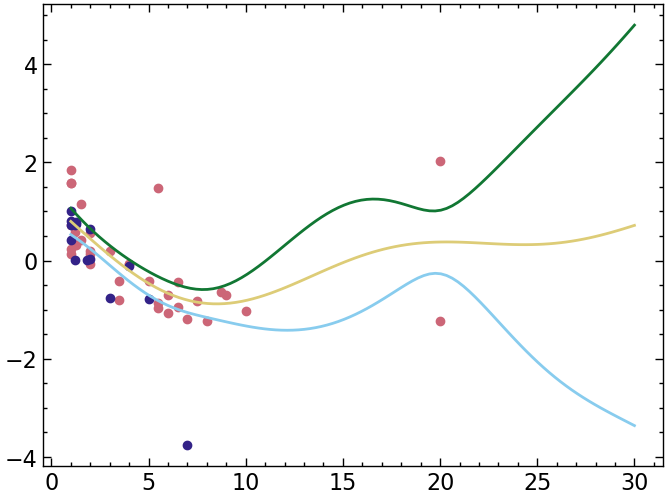

In [1560]:
plt.plot(X_train, y_train,'o')
plt.plot(X_test, y_test,'o')
# plt.plot(X_aug, y_aug,'o')
plt.plot(xx, pred_prime)
plt.plot(xx, pred_prime+pstd_prime)
plt.plot(xx, pred_prime-pstd_prime)


In [1561]:
# Re-sampling from the predicted mean and covariance to verify the mean and covariance.
ys_samples = np.random.multivariate_normal(pred_prime, pcov, size=50)

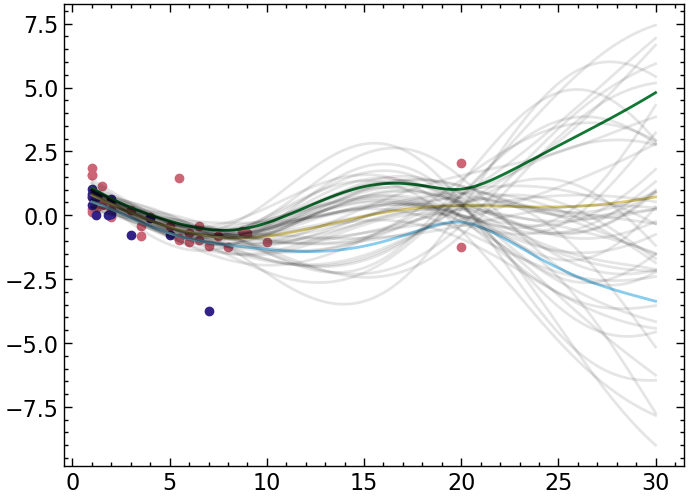

In [1562]:
plt.plot(X_train, y_train,'o')
plt.plot(X_test, y_test,'o')
# plt.plot(X_aug, y_aug,'o')
plt.plot(xx, pred_prime)
plt.plot(xx, pred_prime+pstd_prime)
plt.plot(xx, pred_prime-pstd_prime)

for ys_sample in ys_samples:
    plt.plot(xx, ys_sample, "k-", alpha=0.1)

### Now try this HGP [paper](https://www.researchgate.net/publication/281347768_Sensor_Calibration_and_Hysteresis_Compensation_With_Heteroscedastic_Gaussian_Processes#fullTextFileContent)

In [1563]:
pred_prime_aug, pstd_prime_aug, pcov_aug = study.user_attrs["best_model"].predict(X_aug, return_std=True, return_cov=True)

In [1628]:
# page 5, bottom of col 1
target = (y_aug - pred_prime_aug)**2 - pstd_prime_aug
# target /= np.max(target)

In [1629]:
plt.plot(X_aug, target, 'o')

In [1630]:
X2_train, X2_test, y2_train, y2_test = sklearn.model_selection.train_test_split(X_aug, target, test_size=0.2)

In [1631]:
# https://github.com/tiskw/random-fourier-features/blob/main/rfflearn/tuner/hptuner.py

In [1632]:
# RFFGPR, ORFGPR

In [1671]:
study2 = rfflearn.tuner.RFF_dim_std_tuner(
    rfflearn.cpu.RFFGPR,
    train_set=(X2_train, y2_train),
    valid_set=(X2_test, y2_test),
    verbose=3,
    n_trials=1000,
    std_error=y2_train.std(),
    **{
        "dtype_dim_kernel": "int",
        "range_dim_kernel": {"low": 128, "high": 1024},
        "dtype_std_kernel" : "float",
        "range_std_kernel": {"low": 1e-3, "high": 5.0, "log": True},
        "show_progress_bar":True
    }
)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [1672]:
# Show the result of the hyper parameter tuning.
print("- study.best_params:", study2.best_params)
print("- study.best_value:",  study2.best_value)
print("- study.best_model:",  study2.user_attrs["best_model"])

- study.best_params: {'dim_kernel': 173, 'std_kernel': 0.5735194515306969}
- study.best_value: 0.2698385039136759
- study.best_model: <rfflearn.cpu.rfflearn_cpu_gp.RFFGPR object at 0x7fcc137c87c0>


In [1673]:
study2.user_attrs["best_model"]

In [1674]:
pred_prime2 = study2.user_attrs["best_model"].predict(xx, return_std=False)

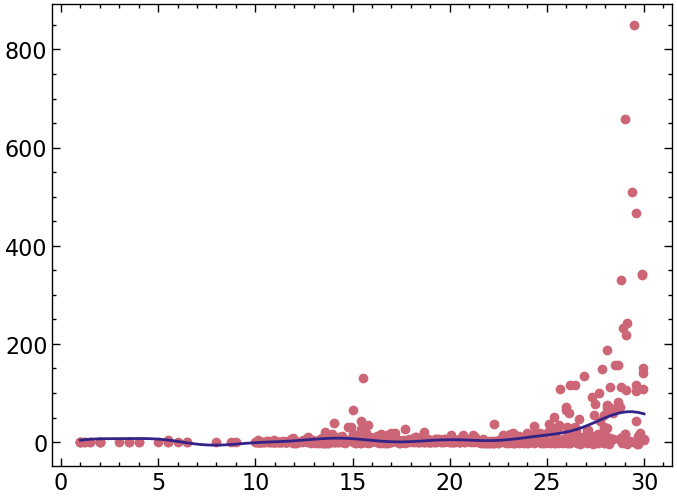

In [1675]:
plt.plot(X2_train, y2_train, 'o')
plt.plot(xx, pred_prime2)

In [1676]:
def hgp(gp1, gp2, xx):
    pred1, std1 = gp1.predict(xx, return_std=True, return_cov=False)
    pred2 = gp2.predict(xx, return_std=False, return_cov=False)

    mu = pred1
    std = std1 + pred2
    std = np.max([np.zeros_like(std), std], axis=0)
    return std1,  mu, std

In [1677]:
gp1_std, hgp_mu, hgp_std = hgp(study.user_attrs["best_model"], study2.user_attrs["best_model"], xx)

In [1678]:
hgp_mu.shape

(100,)

In [1679]:
hgp_std.shape

(100,)

In [1680]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_test, y_test, 'o')
plt.plot(xx, hgp_mu)
plt.plot(xx, hgp_mu-hgp_std)
plt.plot(xx, hgp_mu+hgp_std)

plt.plot(xx, hgp_mu-gp1_std, '--')
plt.plot(xx, hgp_mu+gp1_std, '--')

(-10.0, 10.0)

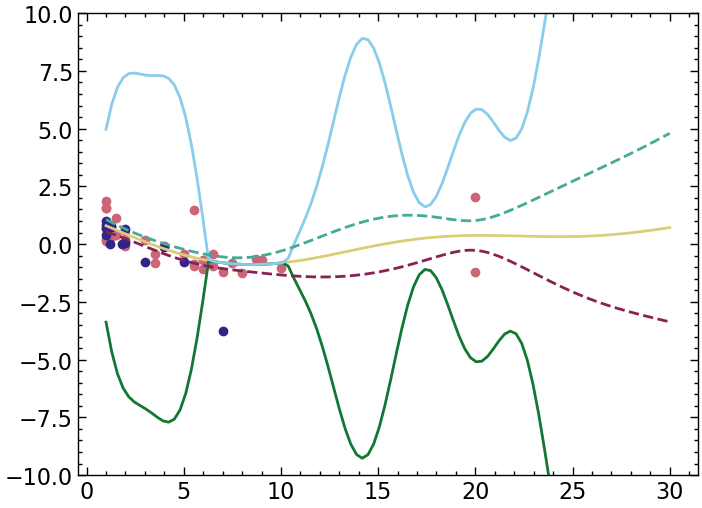

In [1681]:
plt.plot(X_train, y_train, 'o')
plt.plot(X_test, y_test, 'o')
plt.plot(xx, hgp_mu)
plt.plot(xx, hgp_mu-hgp_std)
plt.plot(xx, hgp_mu+hgp_std)

plt.plot(xx, hgp_mu-gp1_std, '--')
plt.plot(xx, hgp_mu+gp1_std, '--')
plt.ylim(-10, 10)